# PARTE 1

In [5]:
#@title 🔧 Setup: librerie
!pip -q install git+https://github.com/openai/CLIP.git ftfy regex tqdm scikit-learn matplotlib torchvision

import os, math, random, time, numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.datasets import OxfordIIITPet
import clip
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances
import torchvision.transforms.functional as TF



SEED = 7
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model, preprocess = clip.load("ViT-B/32", device=device) # ViT-L/14, ViT-bigG
model.eval();


  Preparing metadata (setup.py) ... done
Device: cpu


In [6]:
#@title 🐶 Donwload dataset

# ----------------------------
# Simple dataset cell (didactic)
# ----------------------------
import random
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import OxfordIIITPet

# Config
root = "./data"
BATCH = 64
MAX_SAMPLES = 1600   # set None to use the full split
VERBOSE = True       # toggle debug prints

# Download / load test split
preprocess = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                    std=[0.26862954, 0.26130258, 0.27577711]),
    ])


ds_test = OxfordIIITPet(
    root=root,
    split="test",
    target_types="category",
    download=True,
    transform=preprocess,
)

classes = ds_test.classes  # 37 classes (cats + dogs)
if VERBOSE:
    print(f"[Info] Loaded Oxford-IIIT Pet | classes={len(classes)} | total test samples={len(ds_test)}")

# Optional subsampling (for speed in demos)
idx = list(range(len(ds_test)))
if MAX_SAMPLES is not None and MAX_SAMPLES < len(idx):
    random.seed(0)  # make subsampling reproducible
    idx = random.sample(idx, MAX_SAMPLES)
    if VERBOSE:
        print(f"[Info] Subsampling: {len(ds_test)} -> {len(idx)} samples")

ds_sub = Subset(ds_test, idx)

# DataLoader
loader = DataLoader(
    ds_sub,
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

if VERBOSE:
    print(f"[Info] DataLoader ready | batch_size={BATCH} | subset size={len(ds_sub)}")
    # Peek one batch to show shapes
    try:
        x, y = next(iter(loader))  # x: [B, C, H, W], y: [B]
        print(f"[Debug] First batch: images shape={tuple(x.shape)}, dtype={x.dtype}, device={x.device}")
        if torch.is_tensor(y):
            print(f"[Debug] Targets: shape={tuple(y.shape)}, dtype={y.dtype}, device={y.device}")
    except StopIteration:
        print("[Warning] Empty DataLoader (no samples in subset)")


[Info] Loaded Oxford-IIIT Pet | classes=37 | total test samples=3669
[Info] Subsampling: 3669 -> 1600 samples
[Info] DataLoader ready | batch_size=64 | subset size=1600
[Debug] First batch: images shape=(64, 3, 224, 224), dtype=torch.float32, device=cpu
[Debug] Targets: shape=(64,), dtype=torch.int64, device=cpu


In [7]:
classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.004, 1.000]


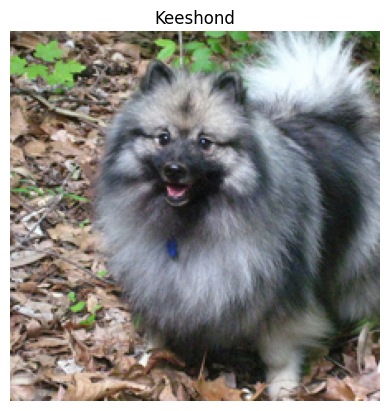

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 1.000]


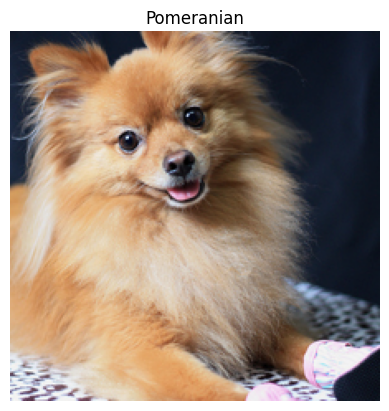

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.016, 1.000]


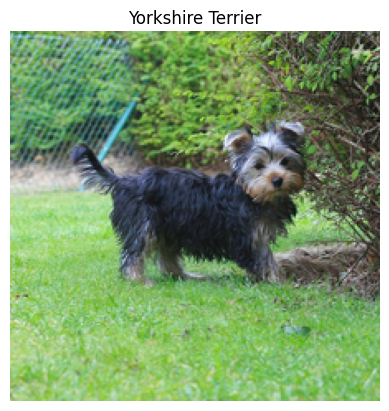

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 1.000]


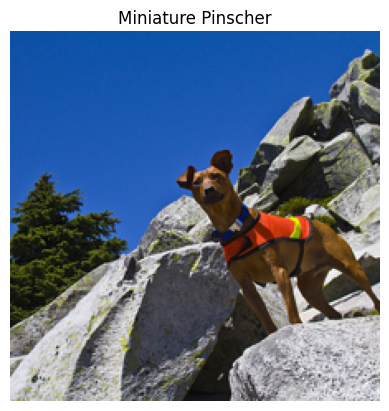

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 1.000]


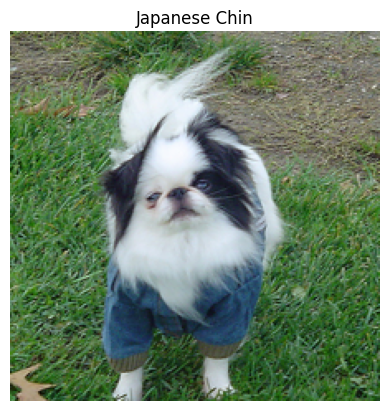

In [10]:


def display_image_from_tensor(image_tensor: torch.Tensor, title=None, verbose: bool = VERBOSE):
    """
    Denormalize and display a single image tensor.

    Args:
        image_tensor: Tensor [C, H, W], normalized with CLIP mean/std.
        title: Optional title (e.g., class label).
        verbose: Print small debug info.
    """
    assert image_tensor.ndim == 3, f"Expected [C,H,W], got {tuple(image_tensor.shape)}"

    # CLIP normalization stats (OpenAI CLIP)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=image_tensor.device)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=image_tensor.device)
    denormalize = torchvision.transforms.Normalize((-mean / std), (1.0 / std))

    # Denormalize (still CHW)
    img_chw = denormalize(image_tensor)

    if verbose:
        c, h, w = img_chw.shape
        print(f"[Debug] image_tensor shape: {tuple(image_tensor.shape)} (C,H,W)")
        print(f"[Debug] after denorm (CHW): shape={tuple(img_chw.shape)}, dtype={img_chw.dtype}, device={img_chw.device}")
        print(f"[Debug] value range (pre-clamp): [{float(img_chw.min()):.3f}, {float(img_chw.max()):.3f}]")

    # Clamp to [0,1] and keep CHW for to_pil_image (expects CHW for torch.Tensor)
    img_chw = torch.clamp(img_chw, 0.0, 1.0)

    # Convert to PIL (CHW tensor is OK)
    img_pil = torchvision.transforms.functional.to_pil_image(img_chw.cpu())

    # Show
    plt.imshow(img_pil)
    plt.axis("off")
    if title is not None:
        plt.title(str(title))
    plt.show()



# --- Show a few random images from ds_sub ---
n_imgs_to_show = 5
for i in random.sample(range(len(ds_sub)), n_imgs_to_show):
    img_tensor, label = ds_sub[i]                 # img_tensor: [C,H,W] (already transformed/preprocessed)
    display_image_from_tensor(img_tensor, classes[label], verbose=VERBOSE)

In [11]:
#@title ⚙️ Numeric utilities

def l2norm(x, axis: int = -1, eps: float = 1e-12, verbose: bool = False):
    """
    L2-normalize array x along 'axis'.
    """
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    out = x / (n + eps)
    if verbose:
        mx = np.max(np.linalg.norm(out, axis=axis))
        mn = np.min(np.linalg.norm(out, axis=axis))
        print(f"[l2norm] axis={axis} | norm range after: min={mn:.4f}, max={mx:.4f}")
    return out


def accuracy_topk(logits: torch.Tensor, targets: torch.Tensor, ks=(1, 5), verbose: bool = False):
    """
    Top-k accuracy for logits [N, C] and integer labels [N].
    Returns a list of accuracies in the same order as 'ks'.
    """
    assert logits.ndim == 2 and targets.ndim == 1, "[accuracy_topk] shapes must be [N,C] and [N]"
    maxk = max(ks)
    pred = torch.topk(logits, k=maxk, dim=1).indices  # [N, maxk]
    res = []
    for k in ks:
        correct = (pred[:, :k] == targets.view(-1, 1)).any(dim=1).float().mean().item()
        res.append(correct)
    if verbose:
        print(f"[accuracy_topk] N={logits.size(0)} C={logits.size(1)} | ks={ks} -> {['{:.3f}'.format(r) for r in res]}")
    return res


def pca_dims(X: np.ndarray, thresholds=(0.90, 0.95), verbose: bool = False):
    """
    Fit PCA on X and report the minimal dimensionality reaching given variance thresholds.
    Returns: (dict threshold->dim, fitted PCA object)
    """
    p = PCA().fit(X)
    c = np.cumsum(p.explained_variance_ratio_)  # cumulative explained variance
    out = {}
    for t in thresholds:
        out[f"dim_{int(t*100)}"] = int(np.searchsorted(c, t) + 1)
    if verbose:
        tot = len(p.explained_variance_ratio_)
        msg = ", ".join([f"{k}={v}" for k, v in out.items()])
        print(f"[pca_dims] X shape={X.shape} | n_components={tot} | {msg}")
    return out, p


def rsa_correlation(I: np.ndarray, T: np.ndarray, verbose: bool = False):
    """
    Representation Similarity Analysis (RSA):
    - I: image features [Ni, D] (assumed unit-normalized)
    - T: text  features [Nt, D] (assumed unit-normalized)
    Computes:
      * S  = I @ T^T                    (Ni x Nt)
      * I_sim = I @ I^T                 (Ni x Ni)  (image-image similarity)
      * Z-score rows of S, then corrcoef over rows -> Ni x Ni text-structure matrix
      * Spearman correlation between upper triangles of I_sim and text-structure
    Returns: (spearman_rho, S)
    """
    # quick norm sanity (not enforcing; just informative)
    if verbose:
        In = np.linalg.norm(I, axis=1)
        Tn = np.linalg.norm(T, axis=1)
        print(f"[rsa] I norms (min,max)=({In.min():.3f},{In.max():.3f}) | T norms (min,max)=({Tn.min():.3f},{Tn.max():.3f})")

    S = I @ T.T                      # [Ni, Nt]
    I_sim = I @ I.T                  # [Ni, Ni]

    # row-wise z-score of S
    S_mu = S.mean(axis=1, keepdims=True)
    S_sd = S.std(axis=1, keepdims=True) + 1e-8
    S_z = (S - S_mu) / S_sd

    # correlation across rows -> Ni x Ni
    I_text_struct = np.corrcoef(S_z)  # uses row vectors

    # compare upper triangles
    iu = np.triu_indices_from(I_sim, k=1)
    rho = spearmanr(I_sim[iu], I_text_struct[iu]).correlation

    if verbose:
        print(f"[rsa] S: {S.shape} | I_sim: {I_sim.shape} | struct: {I_text_struct.shape} | spearman={rho:.4f}")

    return rho, S


def effective_rank(energy: np.ndarray, verbose: bool = False):
    """
    Effective rank given normalized energy (singular-value fractions summing to 1).
    r_eff = exp( - sum_i p_i * log(p_i) ), i.e., exp(entropy) in nats.
    """
    s = float(np.sum(energy))
    if verbose:
        print(f"[effective_rank] energy sum={s:.6f} (should be ~1)")
    # add tiny epsilon inside log to avoid -inf
    r = math.exp(-np.sum(energy * np.log(energy + 1e-12)))
    if verbose:
        print(f"[effective_rank] r_eff={r:.3f}")
    return r



In [12]:
#@title 🖼️ Image embeddings (cached)
VERBOSE = True          # toggle debug prints
L2_NORMALIZE = True     # set False to keep raw features

all_image_feats = []
all_targets = []

model.eval()
with torch.no_grad():
    for b, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device)
        feats = model.encode_image(imgs)  # [B, D]

        if L2_NORMALIZE:
            feats = feats / feats.norm(dim=-1, keepdim=True).clamp_min(1e-12)

        all_image_feats.append(feats.cpu())
        all_targets.append(labels)  # keep on CPU

        if VERBOSE and (b % 20 == 0):
            print(f"[Debug] batch={b:04d} | imgs={tuple(imgs.shape)} -> feats={tuple(feats.shape)} "
                  f"| dtype={feats.dtype} | device={feats.device}")

# Stack/cat to full arrays
all_image_feats = torch.cat(all_image_feats, dim=0).numpy()  # [N, D]
all_targets = torch.cat(all_targets, dim=0)                  # [N]

if VERBOSE:
    print(f"[Info] Cached embeddings: features shape={all_image_feats.shape}, targets shape={tuple(all_targets.shape)}")

print("image_feats:", all_image_feats.shape, "targets:", all_targets.shape)



[Debug] batch=0000 | imgs=(64, 3, 224, 224) -> feats=(64, 512) | dtype=torch.float32 | device=cpu
[Debug] batch=0020 | imgs=(64, 3, 224, 224) -> feats=(64, 512) | dtype=torch.float32 | device=cpu
[Info] Cached embeddings: features shape=(1600, 512), targets shape=(1600,)
image_feats: (1600, 512) targets: torch.Size([1600])


In [14]:
#@title ✍️ Prompt set

VERBOSE = True

def clean_label(lbl):
    """
    Make Oxford-IIIT class names friendlier for CLIP prompts:
    - replace '_' and '-' with spaces
    - trim whitespace
    - lowercase
    """
    return lbl.replace("_", " ").replace("-", " ").strip()

# (A) Baseline: just the class name
templates_baseline = ["{}"]

# (B) Prompt engineering (single context)
templates_engineered = [
    "a photo of a {}.",
]

# (C) Prompt ensemble (10–20 are enough for a toy run; you can go up to ~80)
# Includes some dog/cat-specific variants since classes are dog & cat breeds.
templates_ensemble = [
    "an image of a {}.",
    "a photo of a {}.",
    "a bright photo of a {}.",
    "a low-resolution photo of a {}.",
    "a cropped photo of a {}.",
    "a close-up photo of a {}.",
    "a studio photo of a {}.",
    "a photo of a {}, a type of pet.",
    # dog/cat specific
    "a photo of a {} dog.",
    "a portrait of a {} breed.",
    "a cat of breed {}.",
    "a picture of a {} cat."
]


if VERBOSE:
    print("[Prompts] Counts:",
          f"baseline={len(templates_baseline)},",
          f"engineered={len(templates_engineered)},",
          f"ensemble={len(templates_ensemble)}")
    # Debug example on the first class if available
    try:
        ex_lbl_raw = classes[0]  # assumes `classes` exists in scope
        ex_lbl = clean_label(ex_lbl_raw)
        print(f"[Prompts] Example label: raw='{ex_lbl_raw}' -> clean='{ex_lbl}'")
        print("[Prompts] Example prompts:")
        print("  baseline ->", templates_baseline[0].format(ex_lbl))
        print("  engineered ->", templates_engineered[0].format(ex_lbl))
        print("  ensemble ->", templates_ensemble[0].format(ex_lbl), "...")
    except Exception as _:
        pass


[Prompts] Counts: baseline=1, engineered=1, ensemble=12
[Prompts] Example label: raw='Abyssinian' -> clean='Abyssinian'
[Prompts] Example prompts:
  baseline -> Abyssinian
  engineered -> a photo of a Abyssinian.
  ensemble -> an image of a Abyssinian. ...


In [15]:
#@title 🧠 Zero-shot classifier (class mean text embedding)

VERBOSE = True  # toggle debug prints for this cell

@torch.no_grad()
def zeroshot_weights(
    labels,
    templates,
    model,
    device="cuda",
    normalize: bool = True,
    verbose: bool = VERBOSE,
):
    """
    Build zero-shot classifier weights by averaging CLIP text embeddings
    over prompt templates for each class label.

    Args:
        labels:   list of class names (strings).
        templates:list of prompt templates with a single {} placeholder.
        model:    CLIP-like model exposing .encode_text.
        device:   'cuda' or 'cpu' (where tokenization/encoding will run).
        normalize:if True, L2-normalize per-embedding and the final vector.
        verbose:  print small debug messages.

    Returns:
        W: torch.Tensor of shape [D, C], where:
           - D is the text embedding dimension,
           - C is the number of classes (len(labels)).
    """
    model.eval()

    zs = []
    for i, lbl in enumerate(labels):
        name = clean_label(lbl)                     # e.g., "american bulldog" -> "american bulldog"
        texts = [t.format(name) for t in templates] # apply templates

        # Tokenize and encode on the target device
        tok = clip.tokenize(texts, truncate=True).to(device)  # [T, token_len]
        txt = model.encode_text(tok)                           # [T, D]

        if normalize:
            txt = txt / txt.norm(dim=-1, keepdim=True).clamp_min(1e-12)  # per-template L2

        w = txt.mean(dim=0)                                    # [D]
        if normalize:
            w = w / w.norm().clamp_min(1e-12)                  # final L2

        zs.append(w)

        if verbose and (i % 10 == 0 or i == len(labels) - 1):
            print(f"[ZS] class {i+1:>3}/{len(labels)} | label='{lbl}' | "
                  f"templates={len(texts)} | txt_emb shape={tuple(txt.shape)}")

    W = torch.stack(zs, dim=1)  # [D, C]

    if verbose:
        print(f"[ZS] Built zero-shot weights: shape={tuple(W.shape)} "
              f"(D={W.size(0)}, C={W.size(1)})")

    return W


# Build weights for each prompt set
labels = classes
W_base = zeroshot_weights(labels, templates_baseline,  model, device)
W_eng  = zeroshot_weights(labels, templates_engineered, model, device)
W_ens  = zeroshot_weights(labels, templates_ensemble,  model, device)

W_base.shape, W_eng.shape, W_ens.shape


[ZS] class   1/37 | label='Abyssinian' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
[ZS] class   1/37 | label='Abyssinian' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
[ZS] class   1/37 | label='Abyssinian' | templates=12 | txt_emb shape=(12, 5

(torch.Size([512, 37]), torch.Size([512, 37]), torch.Size([512, 37]))

In [16]:
#@title 🧪 Zero-shot evaluation
def eval_zeroshot(image_feats_np, targets, W):
    I = torch.from_numpy(image_feats_np)  # [N, D]
    I = I.to(W.device)
    logits = I @ W  # [N, C]
    acc1, acc5 = accuracy_topk(logits, targets.to(W.device), ks=(1,5))
    return acc1, acc5

for name, W in [("baseline", W_base), ("engineered", W_eng), ("ensemble", W_ens)]:
    acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, W)
    print(f"{name:>10} | top1={acc1*100:.2f}%  top5={acc5*100:.2f}% ")


  baseline | top1=80.25%  top5=96.63% 
engineered | top1=84.69%  top5=97.56% 
  ensemble | top1=85.94%  top5=97.81% 


In [17]:
#@title 📏 Utility functions (scatter stats)

VERBOSE = True  # toggle debug prints for this cell

def scatter_stats(X, name: str = "X", eps: float = 1e-6, verbose: bool = VERBOSE):
    """
    Compute simple scatter statistics for a set of vectors arranged as:
      rows = samples, cols = features  (shape: [N, D])

    Returns:
      dict with:
        - trace:  trace of covariance matrix (total variance)
        - logdet: log-determinant of (cov + eps*I) (proxy for volume)
        - dim90:  min #PCs to reach 90% variance
        - dim95:  min #PCs to reach 95% variance
        - pca_obj: fitted PCA object (sklearn)
    """
    # Accept torch tensors or numpy arrays
    if torch.is_tensor(X):
        X_np = X.detach().cpu().numpy()
    else:
        X_np = np.asarray(X)

    if verbose:
        print(f"[scatter_stats] {name}: array shape={X_np.shape} (rows=samples, cols=features)")

    # Covariance of features (variables are columns)
    cov = np.cov(X_np, rowvar=False)

    # Stable log-determinant: use cov + eps*I for numerical robustness
    sign, logdet = np.linalg.slogdet(cov + eps * np.eye(cov.shape[0]))
    trace = float(np.trace(cov))

    # PCA to estimate dims at 90% and 95% explained variance
    pca = PCA().fit(X_np)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d90 = int(np.searchsorted(cumsum, 0.90) + 1)
    d95 = int(np.searchsorted(cumsum, 0.95) + 1)

    if verbose:
        print(f"[scatter_stats] {name}: trace={trace:.4f} | logdet={logdet:.4f} | "
              f"dim@90%={d90} | dim@95%={d95}")

    return {
        "trace": trace,
        "logdet": logdet,
        "dim90": d90,
        "dim95": d95,
        "pca_obj": pca,
    }

# Compute stats
img_stats = scatter_stats(all_image_feats, "images")
txt_stats = scatter_stats(W_ens.T, "text (classes as samples)")

# Pretty print
print("BASELINE")
for k, v in [
    ("TRACE (total variance)", (img_stats["trace"],  txt_stats["trace"])),
    ("LOGDET (volume)",        (img_stats["logdet"], txt_stats["logdet"])),
]:
    print(f"{k:>18}:  IMAGES={v[0]:.6f}  |  TEXT={v[1]:.6f}")


[scatter_stats] images: array shape=(1600, 512) (rows=samples, cols=features)
[scatter_stats] images: trace=0.2840 | logdet=-4772.3334 | dim@90%=125 | dim@95%=196
[scatter_stats] text (classes as samples): array shape=(37, 512) (rows=samples, cols=features)
[scatter_stats] text (classes as samples): trace=0.4230 | logdet=-6758.9951 | dim@90%=20 | dim@95%=25
BASELINE
TRACE (total variance):  IMAGES=0.283995  |  TEXT=0.423006
   LOGDET (volume):  IMAGES=-4772.333411  |  TEXT=-6758.995076


In [18]:
#@title 📊 Dispersion and dimensionality (images vs. texts)

VERBOSE = True  # toggle debug prints

# Text: use the **class prototype** space (mean prompts per class), for task consistency
T_base = W_base.T.cpu().numpy()  # shape: [num_classes, dim]
T_eng  = W_eng.T.cpu().numpy()
T_ens  = W_ens.T.cpu().numpy()

I = all_image_feats  # already unit-norm, shape: [num_images, dim]

if VERBOSE:
    print(f"[Shapes] Images: I={I.shape}")
    print(f"[Shapes] Text (baseline):  T_base={T_base.shape}")
    print(f"[Shapes] Text (engineered):T_eng ={T_eng.shape}")
    print(f"[Shapes] Text (ensemble):  T_ens ={T_ens.shape}")

# PCA (images at 90/95%; texts at 90% default unless specified)
dims_img, p_img         = pca_dims(I, thresholds=(0.90, 0.95))
dims_txt_base, _        = pca_dims(T_base)  # defaults to (0.90, 0.95) inside the helper
dims_txt_eng,  _        = pca_dims(T_eng)
dims_txt_ens,  _        = pca_dims(T_ens)

print("PCA dims @90/95% variance:")
print("Images:           ", dims_img,
      "    |\nText baseline:   ", dims_txt_base,
      "|\nText engineered: ", dims_txt_eng,
      "|\nText ensemble:   ", dims_txt_ens)


[Shapes] Images: I=(1600, 512)
[Shapes] Text (baseline):  T_base=(37, 512)
[Shapes] Text (engineered):T_eng =(37, 512)
[Shapes] Text (ensemble):  T_ens =(37, 512)
PCA dims @90/95% variance:
Images:            {'dim_90': 125, 'dim_95': 196}     |
Text baseline:    {'dim_90': 22, 'dim_95': 27} |
Text engineered:  {'dim_90': 21, 'dim_95': 26} |
Text ensemble:    {'dim_90': 20, 'dim_95': 25}


In [19]:
#@title 🔗 Build S with all ensemble prompts (simple & didactic)

VERBOSE = True  # toggle debug prints for this cell

@torch.no_grad()
def all_text_embeddings(labels, templates, model, device="cuda", verbose: bool = VERBOSE):
    """
    Compute text embeddings for *every* (class, template) pair.

    Returns:
        T_all: np.ndarray of shape [num_classes * num_templates, D]
    """
    embs = []
    for i, lbl in enumerate(labels):
        name = clean_label(lbl)                              # e.g., "Egyptian Mau" -> "egyptian mau"
        texts = [t.format(name) for t in templates]          # apply all templates for this class
        tok = clip.tokenize(texts, truncate=True).to(device) # [P, token_len]
        txt = model.encode_text(tok)                         # [P, D]
        txt = txt / txt.norm(dim=-1, keepdim=True).clamp_min(1e-12)  # L2-normalize per row
        embs.append(txt.cpu().numpy())
        if verbose and (i % 10 == 0 or i == len(labels) - 1):
            print(f"[all_text] class {i+1:>3}/{len(labels)} | label='{lbl}' | templates={len(texts)} | emb={tuple(txt.shape)}")
    T_all = np.vstack(embs)  # [C*P, D]
    if verbose:
        print(f"[all_text] stacked text embeddings: shape={T_all.shape}")
    return T_all


# --- Baseline prompts ---
T_all_baseline = all_text_embeddings(labels, templates_baseline, model, device)
print("T_all_baseline:", T_all_baseline.shape)  # (num_classes * num_templates, D)

# RSA: image structure vs text-induced structure (baseline)
rsa_img, S = rsa_correlation(I=I, T=T_all_baseline)
print(f"RSA (images vs text-induced, baseline): {rsa_img:.3f}")

# --- Engineered prompts ---
T_all_engineered = all_text_embeddings(labels, templates_engineered, model, device)
print("T_all_engineered:", T_all_engineered.shape)

rsa_img, S = rsa_correlation(I=I, T=T_all_engineered)
print(f"RSA (images vs text-induced, engineered): {rsa_img:.3f}")

# --- Ensemble prompts ---
T_all = all_text_embeddings(labels, templates_ensemble, model, device)
print("T_all:", T_all.shape)

rsa_img, S = rsa_correlation(I=I, T=T_all)
print(f"RSA (images vs text-induced, ensemble): {rsa_img:.3f}")


# --- SVD on S = I @ T_all^T ---
# I: [N, D]  (unit-normalized image features)
# T_all: [C*P, D]  (unit-normalized text features)
# S: [N, C*P] cross-similarity
S_mat = I @ T_all.T
if VERBOSE:
    print(f"[SVD] S shape={S_mat.shape}  (N={S_mat.shape[0]}, M={S_mat.shape[1]})")

U, s, VT = np.linalg.svd(S_mat, full_matrices=False)
energy = (s**2) / (s**2).sum()
cum = np.cumsum(energy)
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
erank = effective_rank(energy)

print(f"\nSVD(S): k90={k90}, k95={k95}, effective-rank≈{erank:.2f}")


[all_text] class   1/37 | label='Abyssinian' | templates=1 | emb=(1, 512)
[all_text] class  11/37 | label='Chihuahua' | templates=1 | emb=(1, 512)
[all_text] class  21/37 | label='Maine Coon' | templates=1 | emb=(1, 512)
[all_text] class  31/37 | label='Scottish Terrier' | templates=1 | emb=(1, 512)
[all_text] class  37/37 | label='Yorkshire Terrier' | templates=1 | emb=(1, 512)
[all_text] stacked text embeddings: shape=(37, 512)
T_all_baseline: (37, 512)
RSA (images vs text-induced, baseline): 0.585
[all_text] class   1/37 | label='Abyssinian' | templates=1 | emb=(1, 512)
[all_text] class  11/37 | label='Chihuahua' | templates=1 | emb=(1, 512)
[all_text] class  21/37 | label='Maine Coon' | templates=1 | emb=(1, 512)
[all_text] class  31/37 | label='Scottish Terrier' | templates=1 | emb=(1, 512)
[all_text] class  37/37 | label='Yorkshire Terrier' | templates=1 | emb=(1, 512)
[all_text] stacked text embeddings: shape=(37, 512)
T_all_engineered: (37, 512)
RSA (images vs text-induced, eng

[PCA] components=512 | dim@90%=125 | dim@95%=196


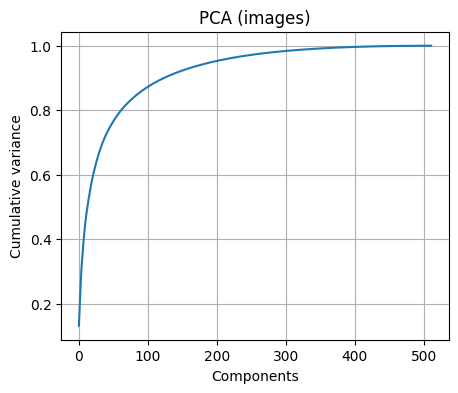

[SVD] singular values=444 | k@90%=1 | k@95%=1


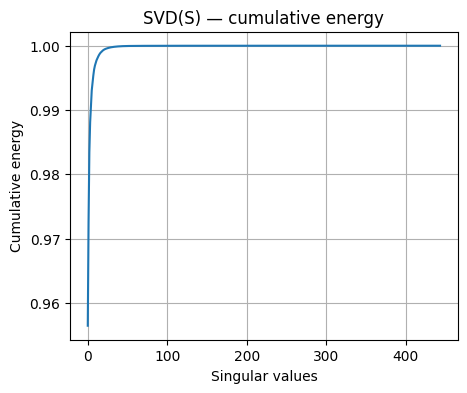

In [21]:
#@title 📈 Plots (PCA & SVD)

VERBOSE = True  # toggle debug prints

# --- PCA (images) ---
cum_var = np.cumsum(p_img.explained_variance_ratio_)  # 1D array
if VERBOSE:
    k90 = int(np.searchsorted(cum_var, 0.90) + 1)
    k95 = int(np.searchsorted(cum_var, 0.95) + 1)
    print(f"[PCA] components={len(cum_var)} | dim@90%={k90} | dim@95%={k95}")

plt.figure(figsize=(5, 4))
plt.plot(cum_var)
plt.xlabel("Components")
plt.ylabel("Cumulative variance")
plt.title("PCA (images)")
plt.grid(True)
plt.show()

# --- SVD(S) cumulative energy ---
cum_energy = np.cumsum(energy)  # 'energy' from the SVD(S) cell
if VERBOSE:
    k90_e = int(np.searchsorted(cum_energy, 0.90) + 1)
    k95_e = int(np.searchsorted(cum_energy, 0.95) + 1)
    print(f"[SVD] singular values={len(cum_energy)} | k@90%={k90_e} | k@95%={k95_e}")

plt.figure(figsize=(5, 4))
plt.plot(cum_energy)
plt.xlabel("Singular values")
plt.ylabel("Cumulative energy")
plt.title("SVD(S) — cumulative energy")
plt.grid(True)
plt.show()


In [23]:
#@title 🧾 Final report

VERBOSE = True  # toggle debug prints for this cell

def eval_and_report(verbose: bool = VERBOSE):
    rows = []
    for name, W in [("baseline", W_base), ("engineered", W_eng), ("ensemble", W_ens)]:
        if verbose:
            print(f"[Eval] Running zero-shot for '{name}'...")
        acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, W)
        rows.append((name, acc1, acc5))
        if verbose:
            print(f"[Eval] {name:>10} -> top1={acc1*100:.2f}% | top5={acc5*100:.2f}%")
    return rows

rows = eval_and_report(VERBOSE)

print("\n== Zero-shot accuracy ==")
for name, a1, a5 in rows:
    print(f"{name:>10}  top1={a1*100:.2f}%  top5={a5*100:.2f}%")

print("\n== PCA dims @90/95% (images vs text) ==")
print("PCA (images vs text): number of components needed to explain variance.")
print("Images:", dims_img)
print("Text baseline:", dims_txt_base, "| engineered:", dims_txt_eng, "| ensemble:", dims_txt_ens)

print("\nRSA(img): correlation between 'native image–image similarity' and "
      "'similarity induced by many text prompts'.")
print(f"RSA (images native vs text-induced using ALL prompts): {rsa_img:.3f}")
print(f"SVD(S): k90={k90}, k95={k95}, effective-rank≈{erank:.2f}")


[Eval] Running zero-shot for 'baseline'...
[Eval]   baseline -> top1=80.25% | top5=96.63%
[Eval] Running zero-shot for 'engineered'...
[Eval] engineered -> top1=84.69% | top5=97.56%
[Eval] Running zero-shot for 'ensemble'...
[Eval]   ensemble -> top1=85.94% | top5=97.81%

== Zero-shot accuracy ==
  baseline  top1=80.25%  top5=96.63%
engineered  top1=84.69%  top5=97.56%
  ensemble  top1=85.94%  top5=97.81%

== PCA dims @90/95% (images vs text) ==
PCA (images vs text): number of components needed to explain variance.
Images: {'dim_90': 125, 'dim_95': 196}
Text baseline: {'dim_90': 22, 'dim_95': 27} | engineered: {'dim_90': 21, 'dim_95': 26} | ensemble: {'dim_90': 20, 'dim_95': 25}

RSA(img): correlation between 'native image–image similarity' and 'similarity induced by many text prompts'.
RSA (images native vs text-induced using ALL prompts): 0.574
SVD(S): k90=125, k95=196, effective-rank≈1.31


In [25]:
#@title 🧪 Simple ablation: template groups

VERBOSE = True  # toggle debug prints for this cell

groups = {
    "generic": [
        "a photo of a {}.",
        "an image of a {}.",
        "a picture of a {}.",
        "a photo of the {}.",
    ],
    "quality": [
        "a bright photo of a {}.",
        "a low-resolution photo of a {}.",
        "a cropped photo of a {}.",
        "a close-up photo of a {}.",
        "a studio photo of a {}.",
    ],
    "domain_pet": [
        "a photo of a {}, a type of pet.",
        "a photo of a {} dog.",
        "a portrait of a {} breed.",
        "a cat of breed {}.",
        "a picture of a {} cat.",
    ],
}

ablation = {}
for gname, gtemps in groups.items():
    if VERBOSE:
        print(f"[Ablation] Group='{gname}' | #templates={len(gtemps)}")
    # Build zero-shot weights for this group
    Wg = zeroshot_weights(labels, gtemps, model, device, verbose=VERBOSE)
    # Evaluate
    acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, Wg)
    ablation[gname] = (acc1, acc5)
    if VERBOSE:
        print(f"[Ablation] {gname:>10} -> top1={acc1*100:.2f}% | top5={acc5*100:.2f}%")

print("\nAblation (top1/top5):")
for k, (a1, a5) in ablation.items():
    print(f"{k:>10}  {a1*100:.2f}% / {a5*100:.2f}%")


[Ablation] Group='generic' | #templates=4
[ZS] class   1/37 | label='Abyssinian' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=4 | txt_emb shape=(4, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
[Ablation]    generic -> top1=84.56% | top5=97.56%
[Ablation] Group='quality' | #templates=5
[ZS] class   1/37 | label='Abyssinian' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=5 | txt_emb shape=(5, 512)
[

In [26]:
#@title ➕ Orthogonal templates (scene / framing / action / light / view / count)

orthogonal_templates = [
    # scene
    "an indoor photo of a {}.",
    "an outdoor photo of a {}.",
    # framing
    "a wide shot of a {}.",
    "a close-up photo of a {}.",
    # action
    "a {} running.",
    "a {} sleeping.",
    "a {} jumping.",
    # lighting
    "a {} at night.",
    "a {} in daylight.",
    # viewpoint
    "a side view of a {}.",
    "a front view of a {}.",
    # count
    "a single {}.",
    "two {}s together.",
]

# Do not modify templates_ensemble: build a separate "super-ensemble"
templates_super_ensemble = templates_ensemble + orthogonal_templates
len(templates_super_ensemble)


25

In [27]:
#@title 🧠 Zero-shot classifier with super-ensemble (without touching W_ens)

VERBOSE = True  # toggle debug prints

@torch.no_grad()
def zeroshot_weights_safe(labels, templates, model, device="cuda", verbose: bool = VERBOSE):
    """
    Same as zeroshot_weights, but kept separate to avoid overwriting existing weights.
    Builds class prototypes by averaging text embeddings over the given templates.
    Returns W of shape [D, C].
    """
    model.eval()
    zs = []
    for i, lbl in enumerate(labels):
        name = clean_label(lbl)
        texts = [t.format(name) for t in templates]
        tok = clip.tokenize(texts, truncate=True).to(device)   # [T, token_len]
        txt = model.encode_text(tok)                            # [T, D]
        txt = txt / txt.norm(dim=-1, keepdim=True).clamp_min(1e-12)
        w = txt.mean(dim=0)                                     # [D]
        w = w / w.norm().clamp_min(1e-12)
        zs.append(w)
        if verbose and (i % 10 == 0 or i == len(labels) - 1):
            print(f"[ZS/safe] class {i+1:>3}/{len(labels)} | label='{lbl}' | templates={len(texts)} | txt_emb={tuple(txt.shape)}")
    W = torch.stack(zs, dim=1)  # [D, C]
    if verbose:
        print(f"[ZS/safe] Built W_super: shape={tuple(W.shape)}")
    return W

# Build super-ensemble weights (does not modify W_ens)
W_super = zeroshot_weights_safe(classes, templates_super_ensemble, model, device, verbose=VERBOSE)

# Evaluate (reuse the simple evaluator)
acc1_super, acc5_super = eval_zeroshot(all_image_feats, all_targets, W_super)

print(f"super-ensemble | top1={acc1_super*100:.2f}%  top5={acc5_super*100:.2f}%")


[ZS/safe] class   1/37 | label='Abyssinian' | templates=25 | txt_emb=(25, 512)
[ZS/safe] class  11/37 | label='Chihuahua' | templates=25 | txt_emb=(25, 512)
[ZS/safe] class  21/37 | label='Maine Coon' | templates=25 | txt_emb=(25, 512)
[ZS/safe] class  31/37 | label='Scottish Terrier' | templates=25 | txt_emb=(25, 512)
[ZS/safe] class  37/37 | label='Yorkshire Terrier' | templates=25 | txt_emb=(25, 512)
[ZS/safe] Built W_super: shape=(512, 37)
super-ensemble | top1=85.87%  top5=97.56%


In [28]:
#@title 🔗 Build S with T_all_super and compute RSA + SVD (simple & didactic)

VERBOSE = True  # toggle debug prints

@torch.no_grad()
def all_text_embeddings_safe(labels, templates, model, device="cuda", verbose: bool = VERBOSE):
    """
    Text embeddings for every (class, template) pair (no averaging).
    Returns: np.ndarray [num_classes * num_templates, D]
    """
    embs = []
    for i, lbl in enumerate(labels):
        name = clean_label(lbl)
        texts = [t.format(name) for t in templates]
        tok = clip.tokenize(texts, truncate=True).to(device)
        txt = model.encode_text(tok)                               # [P, D]
        txt = txt / txt.norm(dim=-1, keepdim=True).clamp_min(1e-12)
        embs.append(txt.cpu().numpy())
        if verbose and (i % 10 == 0 or i == len(labels) - 1):
            print(f"[all_text] {i+1:>3}/{len(labels)} | '{lbl}' | templates={len(texts)} | emb={tuple(txt.shape)}")
    T_all = np.vstack(embs)  # [C*P, D]
    if verbose:
        print(f"[all_text] stacked text embeddings: shape={T_all.shape}")
    return T_all


# I: image embeddings (already unit-norm), T_all_super: all prompts (no averaging)
I_np = all_image_feats
T_all_super = all_text_embeddings_safe(classes, templates_super_ensemble, model, device, verbose=VERBOSE)
print("T_all_super:", T_all_super.shape)

def rsa_img_native_vs_text_induced(I: np.ndarray, T: np.ndarray, verbose: bool = VERBOSE):
    """
    RSA between native image-image similarity and similarity induced by text prompts.
    Returns: (spearman_rho, S), where S = I @ T^T.
    """
    # Cross-similarity: images vs all text prompts
    S = I @ T.T                       # [N, C*P]
    # Image-image similarity
    I_sim = I @ I.T                   # [N, N]
    # Row-wise z-score on S, then corrcoef across rows -> [N, N]
    S_mu = S.mean(axis=1, keepdims=True)
    S_sd = S.std(axis=1, keepdims=True) + 1e-8
    S_z = (S - S_mu) / S_sd
    I_text_struct = np.corrcoef(S_z)  # [N, N]
    iu = np.triu_indices_from(I_sim, k=1)

    rho = spearmanr(I_sim[iu], I_text_struct[iu]).correlation
    if verbose:
        print(f"[RSA] I: {I.shape} | T: {T.shape} | S: {S.shape} | rho={rho:.4f}")
    return rho, S

# RSA (images native vs text-induced)
rsa_img_super, S_super = rsa_img_native_vs_text_induced(I_np, T_all_super, verbose=VERBOSE)
print(f"RSA (images native vs text-induced, super-ensemble): {rsa_img_super:.3f}")

# SVD on S and effective rank
U, s, VT = np.linalg.svd(S_super, full_matrices=False)
energy = (s**2) / (s**2).sum()
cum = np.cumsum(energy)
k90_super = int(np.searchsorted(cum, 0.90) + 1)
k95_super = int(np.searchsorted(cum, 0.95) + 1)
effective_rank_super = float(np.exp(-np.sum(energy * np.log(energy + 1e-12))))

if VERBOSE:
    print(f"[SVD] S shape={S_super.shape} | singulars={len(s)} | "
          f"k@90%={k90_super} | k@95%={k95_super} | eff-rank≈{effective_rank_super:.2f}")

print(f"SVD(S) super-ensemble: k90={k90_super}, k95={k95_super}, effective-rank≈{effective_rank_super:.2f}")


[all_text]   1/37 | 'Abyssinian' | templates=25 | emb=(25, 512)
[all_text]  11/37 | 'Chihuahua' | templates=25 | emb=(25, 512)
[all_text]  21/37 | 'Maine Coon' | templates=25 | emb=(25, 512)
[all_text]  31/37 | 'Scottish Terrier' | templates=25 | emb=(25, 512)
[all_text]  37/37 | 'Yorkshire Terrier' | templates=25 | emb=(25, 512)
[all_text] stacked text embeddings: shape=(925, 512)
T_all_super: (925, 512)
[RSA] I: (1600, 512) | T: (925, 512) | S: (1600, 925) | rho=0.5990
RSA (images native vs text-induced, super-ensemble): 0.599
[SVD] S shape=(1600, 925) | singulars=925 | k@90%=1 | k@95%=1 | eff-rank≈1.33
SVD(S) super-ensemble: k90=1, k95=1, effective-rank≈1.33


# PARTE 3

[SVD] S_super shape=(1600, 925)
[SVD] #singular values=925 | k@90%=1 | k@95%=1 | eff-rank≈1.33

Singular values: 925  |  k90=1, k95=1, effective-rank≈1.33

[Plot] Showing first K=30 singular values


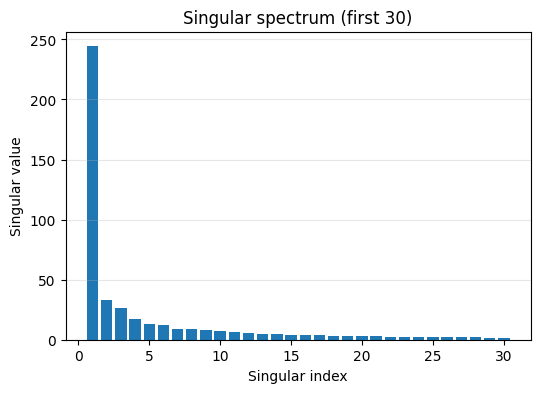

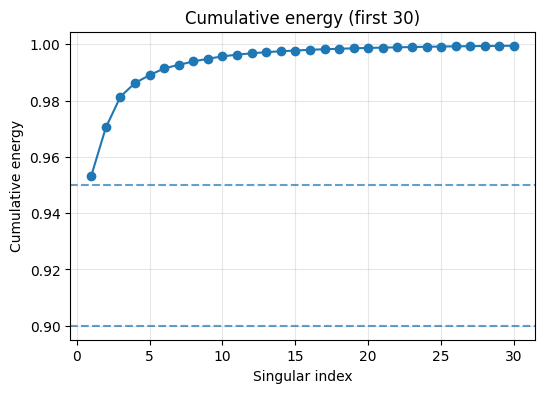

In [29]:
#@title 🔁 S, SVD, and spectrum (bars + cumulative)

VERBOSE = True  # toggle debug prints for this cell

# SVD on S_super (assumes S_super is defined: shape [N_images, N_text_prompts])
U_svd, s_svd, VT_svd = np.linalg.svd(S_super, full_matrices=False)

# Energy of singular values and cumulative energy
energy = (s_svd**2) / (s_svd**2).sum()
cum = np.cumsum(energy)

def effective_rank_from_energy(energy_arr):
    """Effective rank = exp( entropy(energy) ) in nats."""
    return float(np.exp(-np.sum(energy_arr * np.log(energy_arr + 1e-12))))

erank = effective_rank_from_energy(energy)
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)

if VERBOSE:
    print(f"[SVD] S_super shape={S_super.shape}")
    print(f"[SVD] #singular values={len(s_svd)} | k@90%={k90} | k@95%={k95} | eff-rank≈{erank:.2f}\n")

print(f"Singular values: {len(s_svd)}  |  k90={k90}, k95={k95}, effective-rank≈{erank:.2f}\n")

# Plot: first KSHOW singular values + cumulative energy
KSHOW = min(30, len(s_svd))
if VERBOSE:
    print(f"[Plot] Showing first K={KSHOW} singular values")

plt.figure(figsize=(6, 4))
plt.bar(np.arange(1, KSHOW + 1), s_svd[:KSHOW])
plt.xlabel("Singular index")
plt.ylabel("Singular value")
plt.title("Singular spectrum (first 30)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, KSHOW + 1), cum[:KSHOW], marker="o")
plt.axhline(0.90, ls="--", alpha=0.7)
plt.axhline(0.95, ls="--", alpha=0.7)
plt.xlabel("Singular index")
plt.ylabel("Cumulative energy")
plt.title("Cumulative energy (first 30)")
plt.grid(True, alpha=0.3)
plt.show()


[Heatmap] S shape=(1600, 925) | vmin≈0.088 vmax≈0.327 | ks=(1, 5, 10)
[Recon] SVD shapes: U=(1600, 925), s=(925,), VT=(925, 925) | target rank k=1 (S≈1600×925)
[Recon] S_k shape=(1600, 925)
[Recon] SVD shapes: U=(1600, 925), s=(925,), VT=(925, 925) | target rank k=5 (S≈1600×925)
[Recon] S_k shape=(1600, 925)
[Recon] SVD shapes: U=(1600, 925), s=(925,), VT=(925, 925) | target rank k=10 (S≈1600×925)
[Recon] S_k shape=(1600, 925)


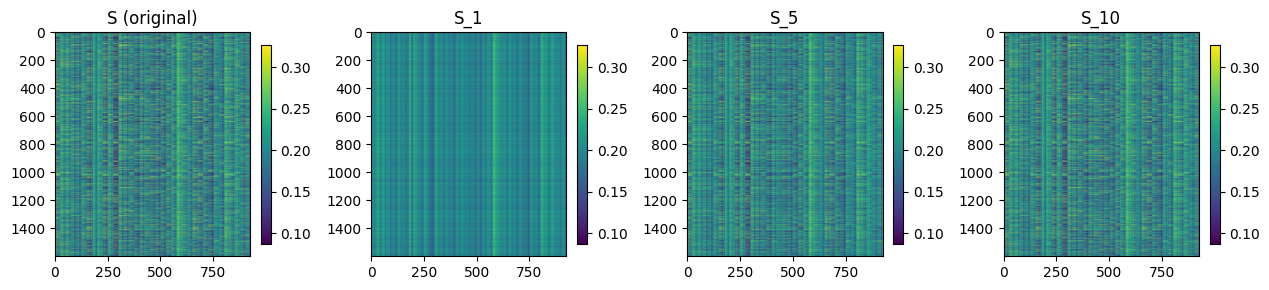

In [30]:
#@title 🔎 Rank-k reconstructions of S + heatmaps (simple & didactic)

VERBOSE = True  # toggle debug prints for this cell

def reconstruct_rank_k(U, s, VT, k, verbose: bool = VERBOSE):
    """
    Reconstruct a rank-k approximation of S from its SVD: S ≈ U_k Σ_k V_k^T
    Args:
        U, s, VT: SVD of S where S = U @ diag(s) @ VT
        k:        rank to keep (k <= min(S.shape))
    Returns:
        S_k: rank-k approximation of S
    """
    if verbose:
        m, n = U.shape[0], VT.shape[1]
        print(f"[Recon] SVD shapes: U={U.shape}, s={s.shape}, VT={VT.shape} | target rank k={k} (S≈{m}×{n})")

    Uk  = U[:, :k]        # [N, k]
    sk  = s[:k]           # [k]
    VTk = VT[:k, :]       # [k, M]
    Sk  = Uk @ (np.diag(sk) @ VTk)  # [N, M]

    if verbose:
        print(f"[Recon] S_k shape={Sk.shape}")
    return Sk


def show_heatmaps(S, U, s, VT, ks=(1, 5, 10), vmax=None, verbose: bool = VERBOSE):
    """
    Show the original S and a few rank-k reconstructions as heatmaps.
    Uses percentile clipping to avoid outliers dominating the colormap.
    """
    if vmax is None:
        vmax = np.percentile(S, 99)   # reduce outlier influence
    vmin = np.percentile(S, 1)

    if verbose:
        print(f"[Heatmap] S shape={S.shape} | vmin≈{vmin:.3f} vmax≈{vmax:.3f} | ks={ks}")

    ncol = len(ks) + 1
    plt.figure(figsize=(3.2 * ncol, 3))

    # Original S
    plt.subplot(1, ncol, 1)
    plt.imshow(S, aspect="auto", vmin=vmin, vmax=vmax)
    plt.title("S (original)")
    plt.colorbar(fraction=0.046)

    # Rank-k reconstructions
    for j, k in enumerate(ks, start=2):
        Sk = reconstruct_rank_k(U, s, VT, k, verbose=verbose)
        plt.subplot(1, ncol, j)
        plt.imshow(Sk, aspect="auto", vmin=vmin, vmax=vmax)
        plt.title(f"S_{k}")
        plt.colorbar(fraction=0.046)

    plt.tight_layout()
    plt.show()


# Example usage (assumes S_super, U_svd, s_svd, VT_svd are defined from the previous cell)
show_heatmaps(S_super, U_svd, s_svd, VT_svd, ks=(1, 5, 10), vmax=None, verbose=VERBOSE)


[Prompts] total prompts=925 (should match S_super.shape[1]=925)
[Recon] SVD shapes: U=(1600, 925), s=(925,), VT=(925, 925) | target rank k=1 (S≈1600×925)
[Recon] S_k shape=(1600, 925)
[Recon] SVD shapes: U=(1600, 925), s=(925,), VT=(925, 925) | target rank k=5 (S≈1600×925)
[Recon] S_k shape=(1600, 925)

=== Image idx 370 ===
[Image] S row shape=(925,) | S1 row shape=(925,) | S5 row shape=(925,)
[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 0.957]


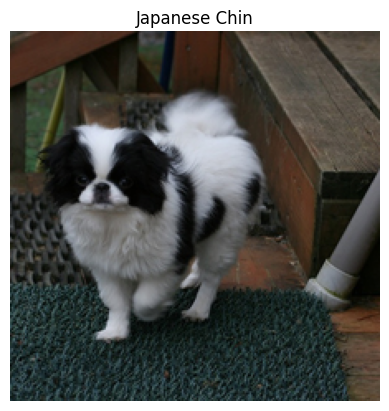

[TopPrompts] image=370 | matrix row shape=(925,) | topk=8

S (full)  | Top-8 prompts:
    0.369  ::  a photo of a Japanese Chin, a type of pet.
    0.368  ::  an outdoor photo of a Japanese Chin.
    0.367  ::  a front view of a Japanese Chin.
    0.364  ::  an image of a Japanese Chin.
    0.360  ::  a photo of a Japanese Chin.
    0.359  ::  a low-resolution photo of a Japanese Chin.
    0.355  ::  a side view of a Japanese Chin.
    0.354  ::  a photo of a Japanese Chin dog.
[TopPrompts] image=370 | matrix row shape=(925,) | topk=8

S_1 (rank-1)  | Top-8 prompts:
    0.298  ::  a photo of a Bombay, a type of pet.
    0.285  ::  a photo of a Persian dog.
    0.282  ::  a photo of a Persian, a type of pet.
    0.278  ::  a photo of a Persian.
    0.278  ::  a cropped photo of a Persian.
    0.277  ::  a cat of breed Bombay.
    0.277  ::  a photo of a Bombay dog.
    0.277  ::  an outdoor photo of a Persian.
[TopPrompts] image=370 | matrix row shape=(925,) | topk=8

S_5 (rank-5)  | To

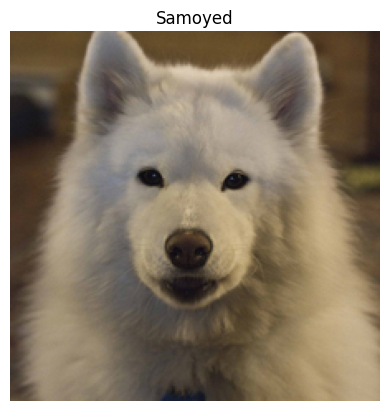

[TopPrompts] image=62 | matrix row shape=(925,) | topk=8

S (full)  | Top-8 prompts:
    0.340  ::  an indoor photo of a Samoyed.
    0.329  ::  a close-up photo of a Samoyed.
    0.329  ::  a close-up photo of a Samoyed.
    0.329  ::  a portrait of a Samoyed breed.
    0.328  ::  a cropped photo of a Samoyed.
    0.325  ::  a front view of a Samoyed.
    0.325  ::  an image of a Samoyed.
    0.323  ::  a low-resolution photo of a Samoyed.
[TopPrompts] image=62 | matrix row shape=(925,) | topk=8

S_1 (rank-1)  | Top-8 prompts:
    0.255  ::  a photo of a Bombay, a type of pet.
    0.244  ::  a photo of a Persian dog.
    0.242  ::  a photo of a Persian, a type of pet.
    0.238  ::  a photo of a Persian.
    0.237  ::  a cropped photo of a Persian.
    0.237  ::  a cat of breed Bombay.
    0.237  ::  a photo of a Bombay dog.
    0.237  ::  an outdoor photo of a Persian.
[TopPrompts] image=62 | matrix row shape=(925,) | topk=8

S_5 (rank-5)  | Top-8 prompts:
    0.262  ::  a photo of a

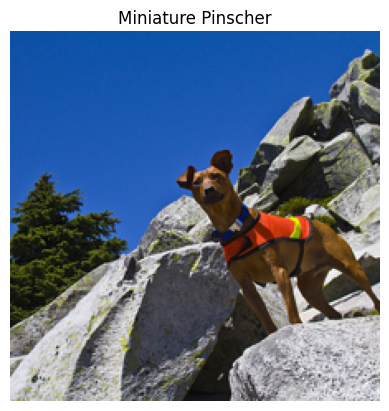

[TopPrompts] image=929 | matrix row shape=(925,) | topk=8

S (full)  | Top-8 prompts:
    0.302  ::  an outdoor photo of a Miniature Pinscher.
    0.302  ::  a bright photo of a Miniature Pinscher.
    0.294  ::  a wide shot of a Miniature Pinscher.
    0.292  ::  a Miniature Pinscher jumping.
    0.288  ::  a cropped photo of a Miniature Pinscher.
    0.287  ::  a photo of a Miniature Pinscher dog.
    0.287  ::  a low-resolution photo of a Miniature Pinscher.
    0.286  ::  a photo of a Miniature Pinscher.
[TopPrompts] image=929 | matrix row shape=(925,) | topk=8

S_1 (rank-1)  | Top-8 prompts:
    0.250  ::  a photo of a Bombay, a type of pet.
    0.240  ::  a photo of a Persian dog.
    0.238  ::  a photo of a Persian, a type of pet.
    0.234  ::  a photo of a Persian.
    0.234  ::  a cropped photo of a Persian.
    0.233  ::  a cat of breed Bombay.
    0.233  ::  a photo of a Bombay dog.
    0.233  ::  an outdoor photo of a Persian.
[TopPrompts] image=929 | matrix row shape=(925

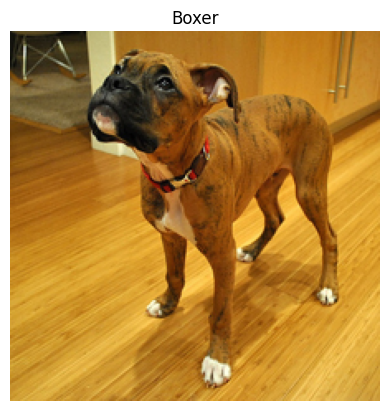

[TopPrompts] image=540 | matrix row shape=(925,) | topk=8

S (full)  | Top-8 prompts:
    0.342  ::  a photo of a Boxer, a type of pet.
    0.337  ::  a front view of a Boxer.
    0.334  ::  a photo of a Boxer dog.
    0.329  ::  an indoor photo of a American Pit Bull Terrier.
    0.328  ::  a cat of breed Boxer.
    0.328  ::  a front view of a Staffordshire Bull Terrier.
    0.326  ::  an indoor photo of a Staffordshire Bull Terrier.
    0.326  ::  a studio photo of a American Pit Bull Terrier.
[TopPrompts] image=540 | matrix row shape=(925,) | topk=8

S_1 (rank-1)  | Top-8 prompts:
    0.271  ::  a photo of a Bombay, a type of pet.
    0.259  ::  a photo of a Persian dog.
    0.257  ::  a photo of a Persian, a type of pet.
    0.252  ::  a photo of a Persian.
    0.252  ::  a cropped photo of a Persian.
    0.252  ::  a cat of breed Bombay.
    0.252  ::  a photo of a Bombay dog.
    0.252  ::  an outdoor photo of a Persian.
[TopPrompts] image=540 | matrix row shape=(925,) | topk=8


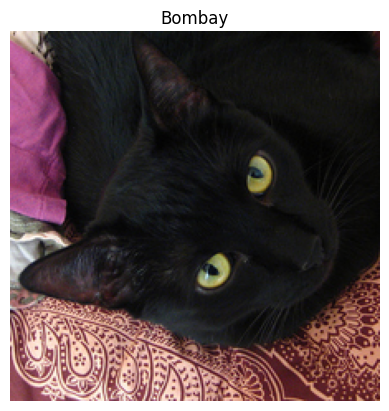

[TopPrompts] image=390 | matrix row shape=(925,) | topk=8

S (full)  | Top-8 prompts:
    0.313  ::  a picture of a Bombay cat.
    0.280  ::  a cropped photo of a Persian.
    0.276  ::  a cropped photo of a Russian Blue.
    0.276  ::  a cropped photo of a Siamese.
    0.276  ::  a photo of a Bombay, a type of pet.
    0.275  ::  a cat of breed Bombay.
    0.275  ::  a low-resolution photo of a Siamese.
    0.272  ::  a low-resolution photo of a Russian Blue.
[TopPrompts] image=390 | matrix row shape=(925,) | topk=8

S_1 (rank-1)  | Top-8 prompts:
    0.258  ::  a photo of a Bombay, a type of pet.
    0.247  ::  a photo of a Persian dog.
    0.245  ::  a photo of a Persian, a type of pet.
    0.241  ::  a photo of a Persian.
    0.240  ::  a cropped photo of a Persian.
    0.240  ::  a cat of breed Bombay.
    0.240  ::  a photo of a Bombay dog.
    0.240  ::  an outdoor photo of a Persian.
[TopPrompts] image=390 | matrix row shape=(925,) | topk=8

S_5 (rank-5)  | Top-8 prompts:
    

In [31]:
#@title 🧩 Top prompts for one image: S vs S1 vs S5 (simple & didactic)

VERBOSE = True  # toggle debug prints for this cell

def top_prompts_for_image(i, S, prompt_strings, topk=8, verbose: bool = VERBOSE):
    """
    Return top-k prompts (indices, scores, texts) for image i given a score matrix S.
    S is [N_images, N_prompts]; prompt_strings is a list of length N_prompts.
    """
    row = S[i]  # shape: [N_prompts]
    idx = np.argsort(-row)[:topk]
    out = [(int(j), float(row[j]), prompt_strings[j]) for j in idx]
    if verbose:
        print(f"[TopPrompts] image={i} | matrix row shape={row.shape} | topk={topk}")
    return out


# Rebuild the exact list of prompt strings used in T_all_super
# Order: for each label in 'classes', all templates in 'templates_super_ensemble'
T_strings = []
for lbl in classes:
    name = clean_label(lbl)
    T_strings += [t.format(name) for t in templates_super_ensemble]
if VERBOSE:
    print(f"[Prompts] total prompts={len(T_strings)} (should match S_super.shape[1]={S_super.shape[1]})")

# Rank-1 and Rank-5 reconstructions of S (use SVD from previous cell)
S1 = reconstruct_rank_k(U_svd, s_svd, VT_svd, 1, verbose=VERBOSE)
S5 = reconstruct_rank_k(U_svd, s_svd, VT_svd, 5, verbose=VERBOSE)

# Show a few random images and their top prompts across S, S1, S5
n_imgs_to_show = 5
for i in random.sample(range(S_super.shape[0]), n_imgs_to_show):
    print(f"\n=== Image idx {i} ===")
    if VERBOSE:
        print(f"[Image] S row shape={S_super[i].shape} | S1 row shape={S1[i].shape} | S5 row shape={S5[i].shape}")

    # Display the image and its class label (assumes ds_sub is aligned with S rows)
    specific_image, specific_label = ds_sub[i]
    display_image_from_tensor(specific_image, classes[specific_label])

    # Compare top prompts from full S and low-rank approximations
    for tag, M in [("S (full)", S_super), ("S_1 (rank-1)", S1), ("S_5 (rank-5)", S5)]:
        tops = top_prompts_for_image(i, M, T_strings, topk=8, verbose=VERBOSE)
        print(f"\n{tag}  | Top-8 prompts:")
        for j, score, txt in tops:
            print(f"  {score:7.3f}  ::  {txt}")


Take-home message 🏡

- **Visual space is bigger.**
Images need many more PCA components to explain their variation than text prompts do. (Think: breed, pose, lighting, background… all add dimensions.)

- **Text only grabs a slice.**
RSA shows that image–image structure recovered from prompts is moderate: prompts explain some similarities, but miss a lot of the visual geometry.

- **One axis rules them all.**
SVD of the image–text similarity matrix is very low-rank (often ≈1). Most of the coupling rides on a single direction (call it “dogness”), while finer factors (breed, pose, style) barely register.

- **Asymmetry matters.**
It’s easier for vision to approximate text structure than for text to approximate visual structure—text space is compact; vision is sprawling.

What to do next

- **Richer prompts, more axes:** vary scene, viewpoint, action, lighting, background, count; compose multiple attributes in one prompt.

- **Use longer, descriptive text:** not just class names—add details that map to visual factors.

- **(Advanced)** Learn better text direction, (prompt tuning/textual inversion) or add model capacity (multi-head/cross-attention) to capture more than one shared axis.